In [1]:
# Imports & Setup
import os
import pickle
import numpy as np
import random
import re
from tqdm.notebook import tqdm
from google.colab import files, drive

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu

# Mount Drive for saving model/features
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Download & Prepare Dataset
files.upload()  # upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d adityajn105/flickr8k
!unzip -q flickr8k.zip -d ./data

BASE_DIR = './data/Images'


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:07<00:00, 152MB/s]
100% 1.04G/1.04G [00:07<00:00, 148MB/s]


In [3]:
# load vgg16 model/
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Feature extraction
features = {}
for img_name in tqdm(os.listdir(BASE_DIR)):
    img_path = os.path.join(BASE_DIR, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, 224, 224, 3))
    image = preprocess_input(image)
    feature = vgg.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

# Save features
with open('/content/drive/MyDrive/features.pkl', 'wb') as f:
    pickle.dump(features, f)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [4]:
# Load features (if needed later)
with open('/content/drive/MyDrive/features.pkl', 'rb') as f:
    features = pickle.load(f)


In [5]:
# Load and clean captions
captions_path = './data/captions.txt'
with open(captions_path, 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

# Clean captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z]', ' ', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = caption.strip()
            caption = 'startseq ' + " ".join([w for w in caption.split() if len(w) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [6]:
# Tokenization
all_captions = []
for key in mapping:
    all_captions.extend(mapping[key])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

print("Vocab size:", vocab_size)
print("Max caption length:", max_length)


Vocab size: 8427
Max caption length: 35


In [7]:
# Split train/test
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [8]:
# Data Generator using Keras Sequence
class CaptionDataGenerator(Sequence):
    def __init__(self, keys, mapping, features, tokenizer, max_length, vocab_size, batch_size=32):
        self.keys = keys
        self.mapping = mapping
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.keys) / float(self.batch_size)))

    def __getitem__(self, idx):
        X1, X2, y = list(), list(), list()
        batch_keys = self.keys[idx*self.batch_size:(idx+1)*self.batch_size]
        for key in batch_keys:
            captions = self.mapping[key]
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                    X1.append(self.features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
        return {"image": np.array(X1), "text": np.array(X2)}, np.array(y)


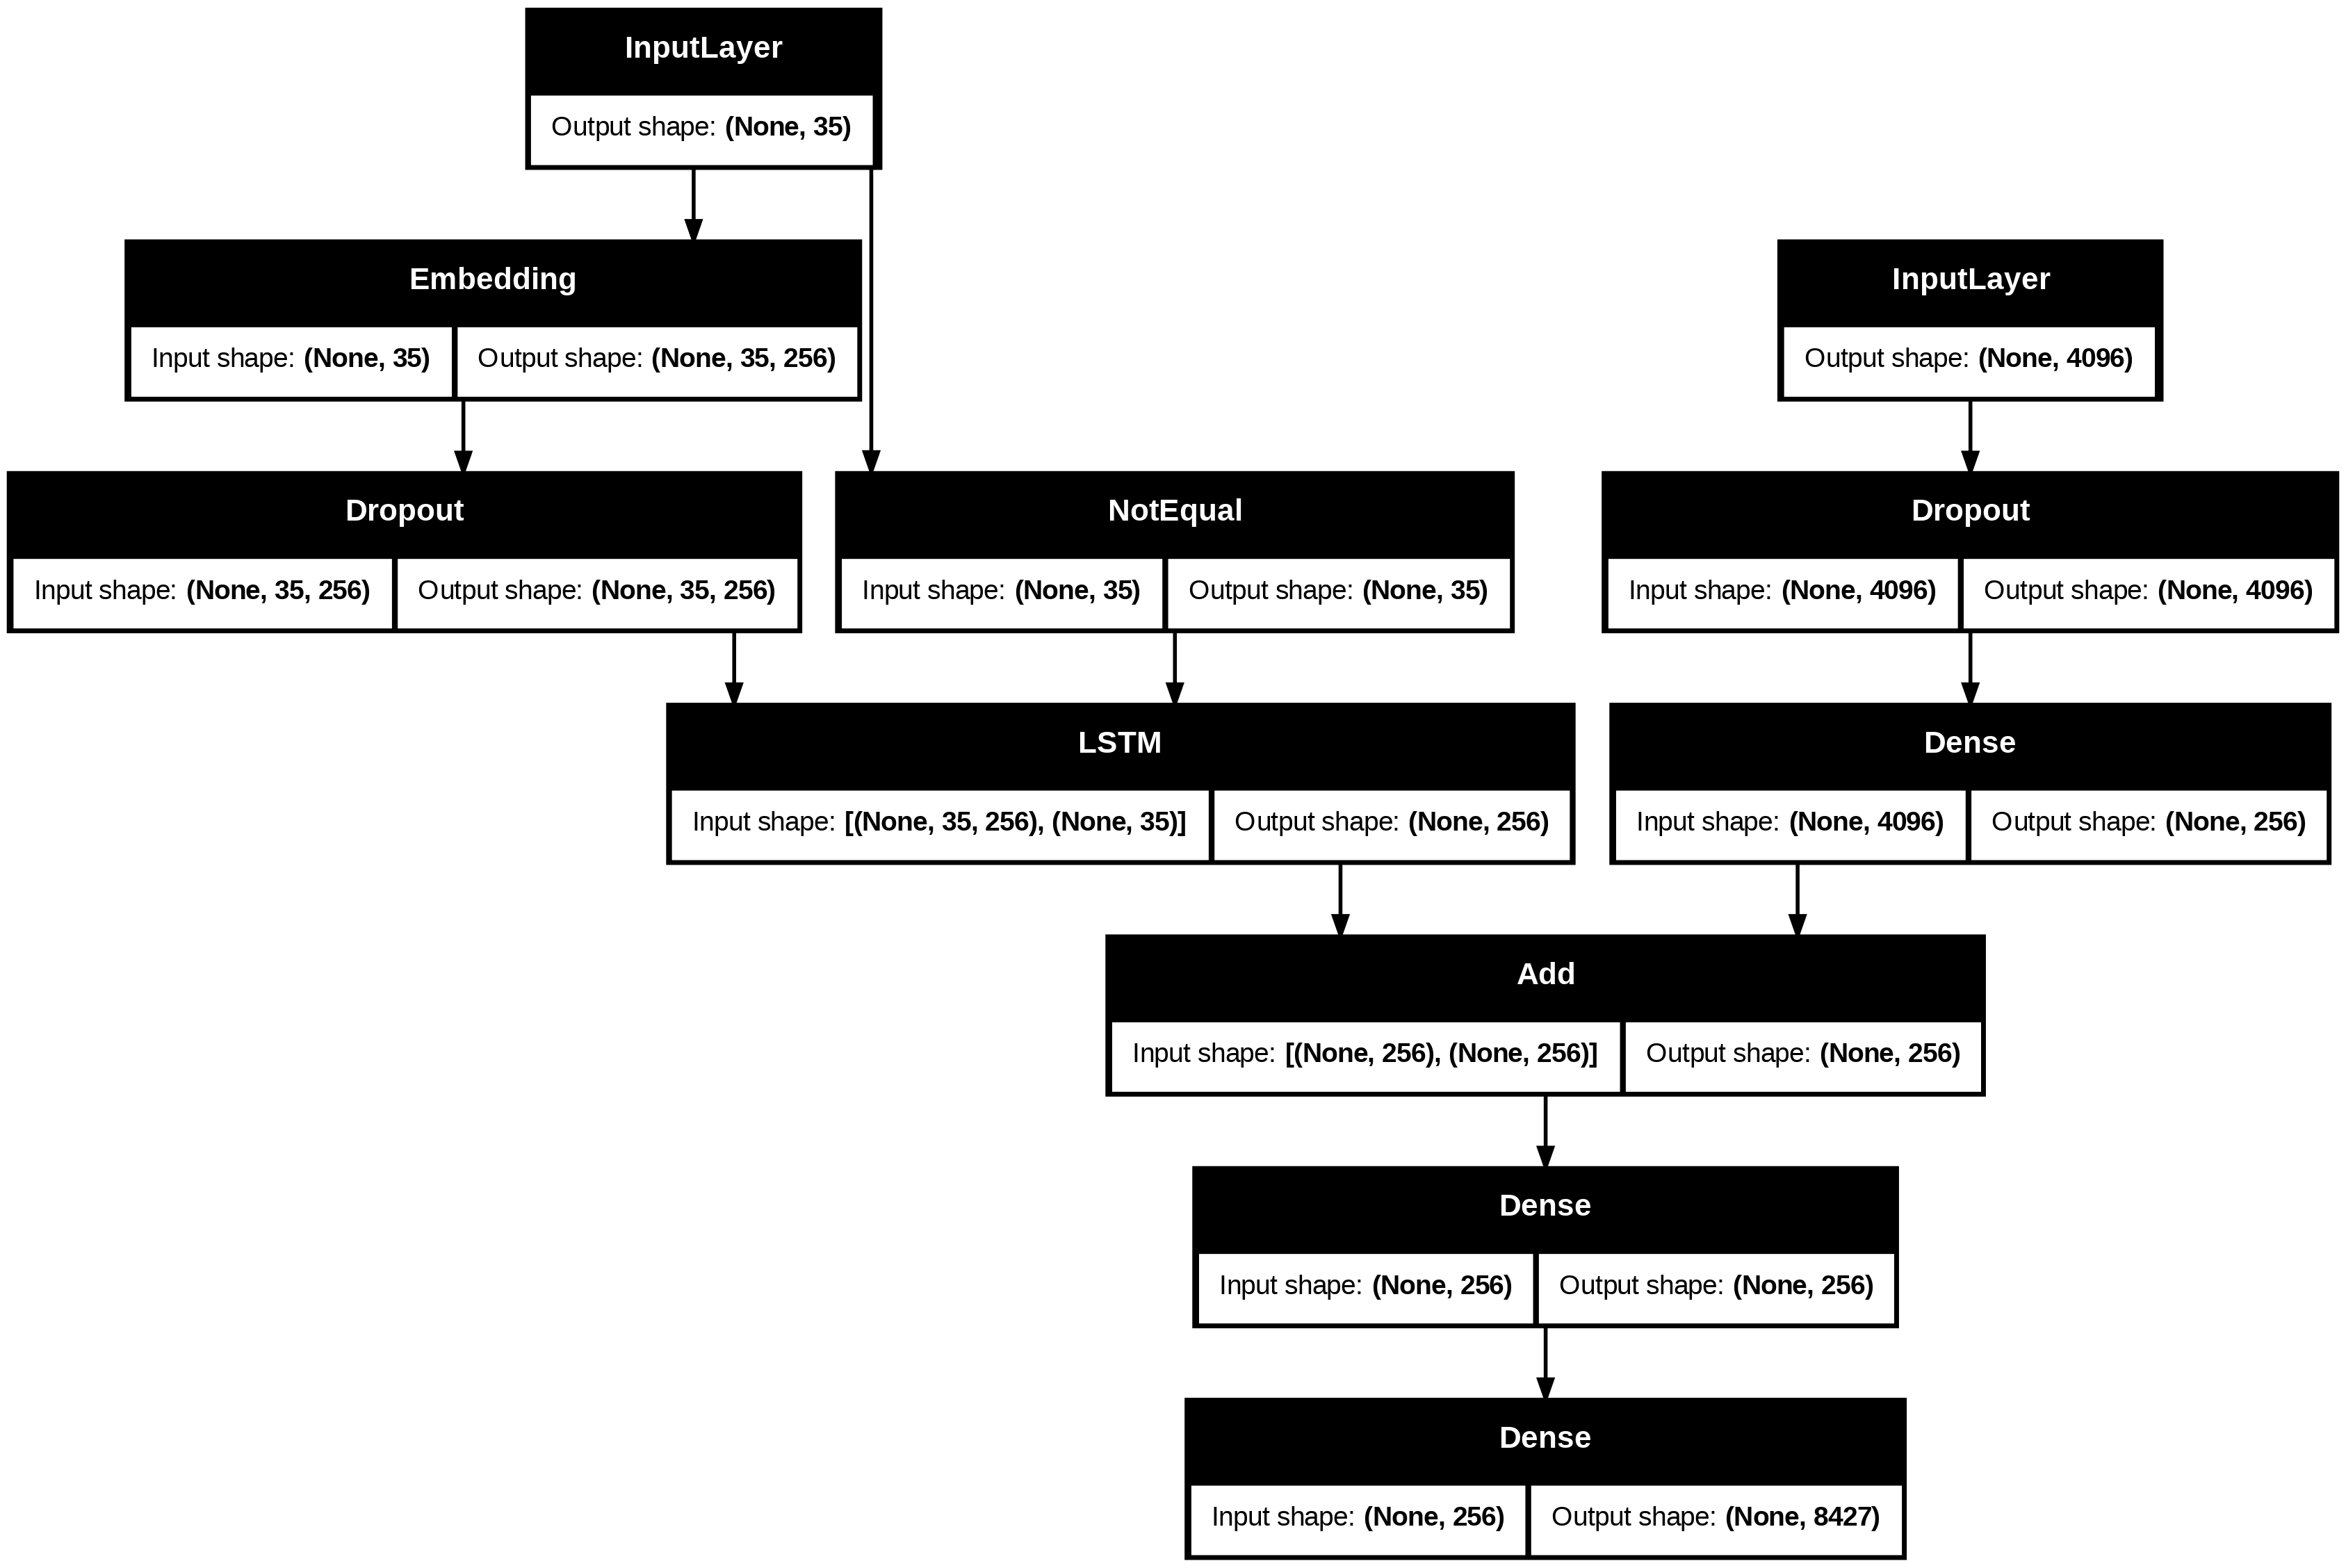

In [9]:
# Model Architecture
clear_session()

inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)


In [10]:
# Training
train_gen = CaptionDataGenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size=16)

epochs = 15
steps = len(train_gen)

model.fit(train_gen, epochs=epochs, steps_per_epoch=steps, verbose=1)

model.save('/content/drive/MyDrive/best_model.keras')


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 5.4697
Epoch 2/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 3.8532
Epoch 3/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 3.4459
Epoch 4/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 3.1803
Epoch 5/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 2.9788
Epoch 6/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 2.8021
Epoch 7/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 2.6823
Epoch 8/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 2.5686
Epoch 9/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 2.4656
Epoch 10/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 2.3906
Epoch 11/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 2.3183
Epoch 12/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 2.2777
Epoch 13/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 2.2110
Epoch 14/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 2.1677
Epoch 15/15
456/456 ━━━━━━━━━━━━━━━━━━━━

In [23]:
# Training for some more epochs

epochs = 15

model.fit(train_gen, epochs=epochs, steps_per_epoch=steps, verbose=1)

model.save('/content/drive/MyDrive/best_model.keras')

Epoch 1/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 1.8125
Epoch 2/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.7892
Epoch 3/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.7716
Epoch 4/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.7480
Epoch 5/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 1.7324
Epoch 6/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.7270
Epoch 7/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.7182
Epoch 8/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.6960
Epoch 9/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.6805
Epoch 10/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.6771
Epoch 11/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.6645
Epoch 12/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 1.6586
Epoch 13/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.6435
Epoch 14/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.6379
Epoch 15/15
456/456 ━━━━━━━━━

In [24]:
# Caption Prediction Helpers
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, max_words=15):
    in_text = 'startseq'
    for _ in range(max_words):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text


In [25]:
# BLEU Score Evaluation
actual, predicted = [], []
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1:", corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.4743384940129111
BLEU-2: 0.28612682710935894


In [26]:
# Display Captions Function
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    print('--- Actual ---')
    for caption in mapping[image_id]:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    y_pred_clean = y_pred.replace('startseq', '').replace('endseq', '').strip()
    print('--- Predicted ---')
    print(y_pred_clean)
    plt.imshow(image)

Selected Image ID: 466956209_2ffcea3941
--- Actual ---
startseq distant person is climbing up very sheer mountain endseq
startseq panoramic distance view of rock climber going up steep mountain wall endseq
startseq person rock climbing endseq
startseq there is person scaling very steep rock wall endseq
startseq this person is climbing the side of mountain endseq
--- Predicted ---
man climbing up mountainside


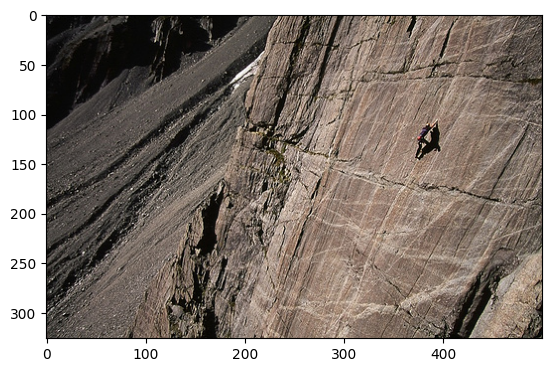

In [30]:
# Display Captions for Random Image
random_img_id = random.choice(test)
print("Selected Image ID:", random_img_id)
generate_caption(random_img_id + '.jpg')

Selected Image ID: 451326127_2d95a2e1c2
--- Actual ---
startseq dog jumping over fallen tree in the forest endseq
startseq dog leaps over tree fallen in the forest endseq
startseq large dog jumping over fallen tree in the forest endseq
startseq large brown dog jumps over low tree trunk in wooded area endseq
startseq the german shepherd is jumping over fallen tree endseq
--- Predicted ---
dog jumps over log in the woods


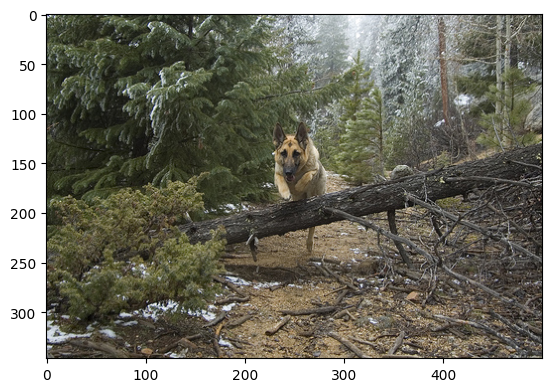

In [32]:
# Display Captions for Random Image
random_img_id = random.choice(test)
print("Selected Image ID:", random_img_id)
generate_caption(random_img_id + '.jpg')

Selected Image ID: 556568556_bc5124dc8e
--- Actual ---
startseq boy that is wearing brown hat and shoes that have red soles is on swing in park endseq
startseq boy with closed eyes wearing hat on swing endseq
startseq boy with red soled shoes is playing on swing endseq
startseq little kid plays on the swing at the playground endseq
startseq young girl swings on swing endseq
--- Predicted ---
boy swinging on swing


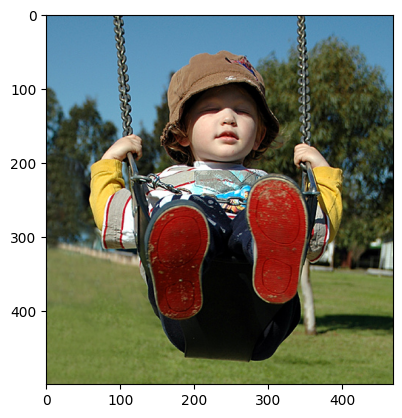

In [36]:
# Display Captions for Random Image
random_img_id = random.choice(test)
print("Selected Image ID:", random_img_id)
generate_caption(random_img_id + '.jpg')